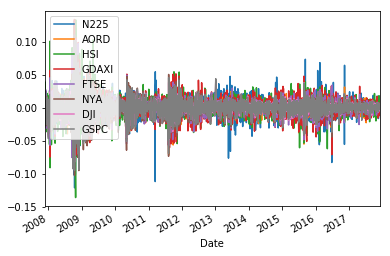

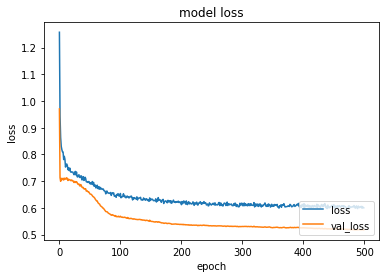

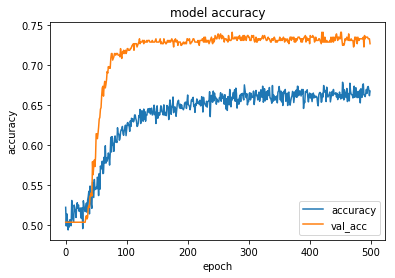

Individual accuracy [0.73251027, 0.72064775]
accuracy 0.726530612245
Final_Answer : [ 0.51692915  0.48307091]


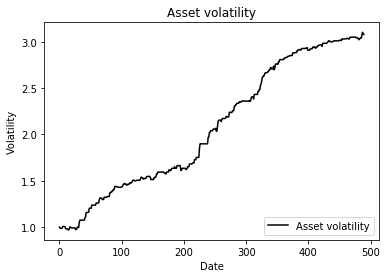

Final_Asset : 3.07836049873 



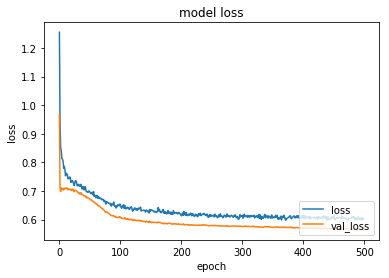

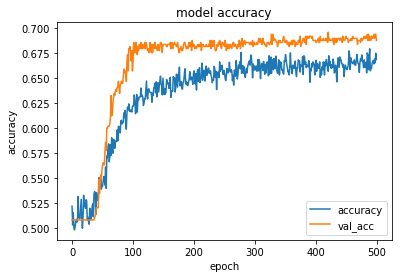

Individual accuracy [0.6514523, 0.72289157]
accuracy 0.687755102041
Final_Answer : [ 0.41313756  0.58686244]


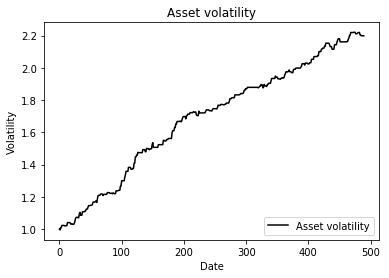

Final_Asset : 2.19863759675 



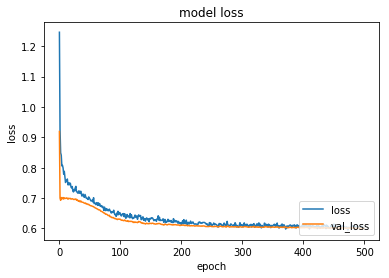

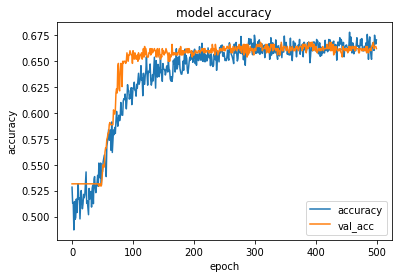

Individual accuracy [0.63913041, 0.68199235]
accuracy 0.661914460285
Final_Answer : [ 0.56548387  0.4345161 ]


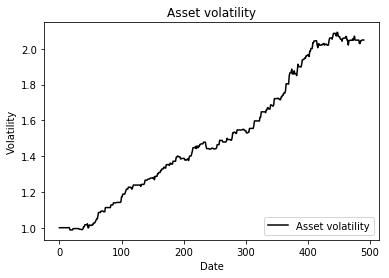

Final_Asset : 2.04962034685 



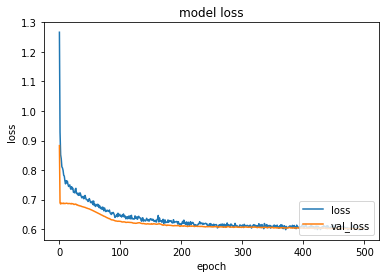

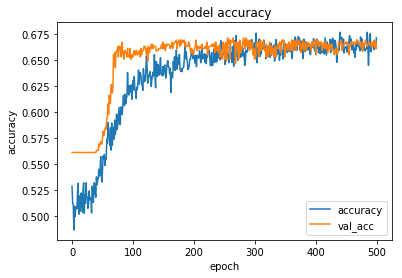

Individual accuracy [0.65581393, 0.66545457]
accuracy 0.661224489796
Final_Answer : [ 0.18863121  0.81136876]


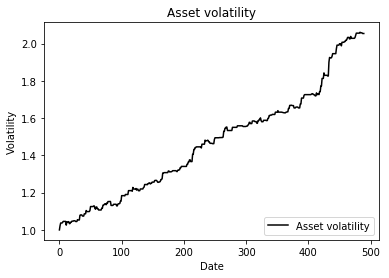

Final_Asset : 2.05414580402 



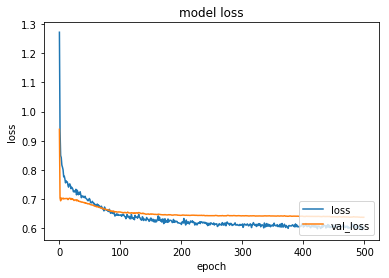

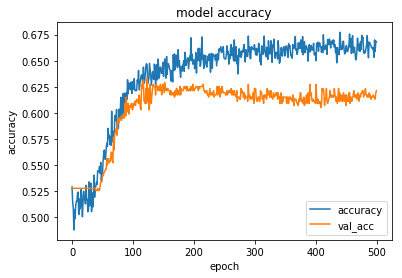

Individual accuracy [0.61637932, 0.62548262]
accuracy 0.621181262729
Final_Answer : [ 0.49857122  0.50142878]


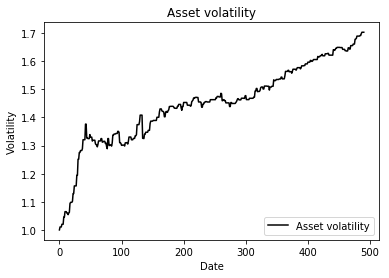

Final_Asset : 1.70309496211 

elapsed_time : 105.99169087409973 [sec]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from keras_model import Model

# ダウンロードしてきたやつ
INDEIES = ["N225",
           "AORD",
           "HSI",
           "GDAXI",
           "FTSE",
           "NYA",
           "DJI",
           "GSPC",
          ]
ANSWER = "N225"

def getClosing():
    closing = pd.DataFrame()
    for index in INDEIES:
        # na_valuesは文字列"null"のとき空として扱う
        df = pd.read_csv("../data/input5/" + index + ".csv", na_values=["null"])
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.set_index("Date")
        closing[index] = df["Close"]
        if index is ANSWER:
            closing["LH"] = (df["Close"].shift()-df["Low"])*(df["High"]-df["Close"].shift())
    # 空の部分は古いので埋める
    closing = closing.fillna(method="ffill")
    LH = np.array(closing["LH"])
    del closing["LH"]
    for index in INDEIES:
        #closing[index] = closing[index] / max(closing[index])
        closing[index] = np.log(closing[index] / closing[index].shift())
    #グラフ表示
    closing.plot()
    plt.show()
    closing["negative"] = 0
    # closing[ANSWER] < 0 の行のnegativeに 1
    closing.loc[closing[ANSWER] < 0, "negative"] = 1
    closing["positive"] = 0
    # closing[ANSWER] >= 0 の行のpositiveに 1
    closing.loc[closing[ANSWER] >= 0, "positive"] = 1
    return closing, LH

def getTraningData():
    closing, LH = getClosing()
    # 1~3日前のデータを予測に使う
    days_before = range(1,4)
    answers = pd.DataFrame(columns = ["negative", "positive"])
    columns = []
    for index in INDEIES:
        columns += [index + "_" + str(before) for before in days_before]
    features = pd.DataFrame(columns = columns)
    for i in range(4, len(closing)):
        # 予測の部分は当日のデータ
        answers = answers.append({
            "negative" : closing["negative"].iloc[i],
            "positive" : closing["positive"].iloc[i]}, ignore_index=True)
        data={}
        # ほかの指標は１個前のデータ
        for index in INDEIES:
            for before in days_before :
                data[index + "_" + str(before)] = closing[index].iloc[i - before]
        features = features.append(data, ignore_index=True)
    for i in days_before :
        drop_col = ANSWER+"_"+str(i)
        #del features[drop_col] # 予測するデータの過去データを入れないとき
    # 予測する元のデータ , 予測するべきデータ
    return features, answers, LH

if __name__ == "__main__":
    start = time.time()
    features, answers, LH = getTraningData()
    popo = 5
    for test in range(0,popo):
        layers = [50,25]
        model = Model(features,answers,layers,test*(1/popo),test*(1/popo)+(1/popo))
        model.train()
        model.test()
        model.value(ANSWER+"_1", LH)
    print("elapsed_time :", time.time()-start, "[sec]")